# Classification Project

1. [Goals](#Goals)
1. [Questions](#Questions)
1. [Specification](#Specification)
1. [Deliverables](#Deliverables)
1. [Prepare the Environment](#Prepare-the-Environment)
1. [Acquistion](#Acquisition)
1. [Data Prep](#Data-Prep)
1. [Data Exploration](#Data-Exploration)
1. [Modeling](#Modeling)

### Goals

- Why are our customers churning?

### Questions

- Could the month in which they signed up influence churn? i.e. if a cohort is identified by tenure, is there a cohort or cohorts who have a higher rate of churn than other cohorts? (Plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers))

- Are there features that indicate a higher propensity to churn? like type of 
internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?

- Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?

- If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

### Deliverables

1. I will also need a report (ipynb) answering the question, "Why are our customers churning?" I want to see the analysis you did to answer my questions and lead to your findings. Please clearly call out the questions and answers you are analyzing. E.g. If you find that month-to-month customers churn more, I won't be surprised, but I am not getting rid of that plan. The fact that they churn is not because they can, it's because they can and they are motivated to do so. I want some insight into why they are motivated to do so. I realize you will not be able to do a full causal experiment, but I hope to see some solid evidence of your conclusions.

2. I will need you to deliver to me a csv with the customer_id, probability of churn, and the prediction of churn (1=churn, 0=not_churn). I would also like a single goolgle slide that illustrates how your model works, including the features being used, so that I can deliver this to the SLT when they come with questions about how these values were derived. Please make sure you include how likely your model is to give a high probability of churn when churn doesn't occur, to give a low probability of churn when churn occurs, and to accurately predict churn.

3. Finally, our development team will need a .py file that will take in a new dataset, (in the exact same form of the one you acquired from telco_churn.customers) and perform all the transformations necessary to run the model you have developed on this new dataset to provide probabilities and predictions.

### Specification

Detailed instructions for each section are below.

In general, make sure you document your work. You don't need to explain what every line of code is doing, but you should explain what and why you are doing. For example, if you drop a feature from the dataset, you should explain why you decided to do so, or why that is a reasonable thing to do. If you transform the data in a column, you should explain why you are making that transformation.

In addition, you should not present numers in isolation. If your code outputs a number, be sure you give some context to the number.

Specific Deliverables:

- a jupyter notebook where your work takes place
- a csv file that predicts churn for each customer
- a python script that prepares data such that it can be fed into your model
- a google slide summarizing your model
- a README.md file that contains a link to your google slides presentation, and instructions for how to use your python script(s)

## Prepare the Environment

In [25]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from pydataset import data

# Logistc Regression
from sklearn.linear_model import LogisticRegression

# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# KNN
from sklearn.neighbors import KNeighborsClassifier

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# All modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import MinMaxScaler

import graphviz

from graphviz import Graph

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns

from env import host, user, password

## Acquisition

1. Get the data from the ```customers``` table from the ```telco_churn``` database on the codeup data science database server.

    - You may wish to join some tables as part of your query.
    - This data should end up in a pandas data frame.

In [2]:
def get_db_url(hostname: str, username: str, password: str, db_name: str) -> str:
    return f"mysql+pymysql://{username}:{password}@{hostname}/{db_name}"


def get_sql_conn(hostname: str, username: str, password: str, db_name: str):
    return create_engine(get_db_url(host, user, password, db_name))


def df_from_sql(query: str, url: str) -> pd.DataFrame:
    return pd.read_sql(query, url)


def get_telco_data() -> pd.DataFrame:
    db = "telco_churn"
    query = ("SELECT * "
             f"FROM customers;")
    url = get_db_url(host, user, password, db)
    return df_from_sql(query, url)

In [3]:
df = get_telco_data()

In [4]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,1,No,...,No,Yes,Yes,No,2,Yes,2,65.6,593.3,No
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,No,...,No,No,No,Yes,1,No,2,59.9,542.4,No
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,2,No,...,Yes,No,No,No,1,Yes,1,73.9,280.85,Yes
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,2,No,...,Yes,No,Yes,Yes,1,Yes,1,98.0,1237.85,Yes
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,2,No,...,No,Yes,Yes,No,1,Yes,2,83.9,267.4,Yes


2. Write a function, ```peekatdata(dataframe)```, that takes a dataframe as input and computes and returns the following:

    - creates dataframe object ```head_df``` (df of the first 5 rows) and prints contents to screen

    - creates dataframe object ```tail_df``` (df of the last 5 rows) and prints contents to screen

    - creates tuple object ```shape_tuple``` (tuple of (nrows, ncols)) and prints tuple to screen

    - creates dataframe object ```describe_df``` (summary statistics of all numeric variables) and prints contents to screen.

    - prints to screen the information about a DataFrame including the index dtype and column dtypes, non-null values and memory usage.

In [5]:
def peekatdata(dataframe):
    head_df = dataframe.head()
    print(f"HEAD\n{head_df}", end="\n\n")

    tail_df = dataframe.tail()
    print(f"TAIL\n{tail_df}", end="\n\n")

    shape_tuple = dataframe.shape
    print(f"SHAPE: {shape_tuple}", end="\n\n")

    describe_df = dataframe.describe()
    print(f"DESCRIPTION\n{describe_df}", end="\n\n")

    print(f"INFORMATION")
    dataframe.info()

In [6]:
peekatdata(df)

HEAD
  customer_id  gender  senior_citizen partner dependents  tenure  \
0  0002-ORFBO  Female               0     Yes        Yes       9   
1  0003-MKNFE    Male               0      No         No       9   
2  0004-TLHLJ    Male               0      No         No       4   
3  0011-IGKFF    Male               1     Yes         No      13   
4  0013-EXCHZ  Female               1     Yes         No       3   

  phone_service multiple_lines  internet_service_type_id online_security  \
0           Yes             No                         1              No   
1           Yes            Yes                         1              No   
2           Yes             No                         2              No   
3           Yes             No                         2              No   
4           Yes             No                         2              No   

   ...  device_protection tech_support streaming_tv streaming_movies  \
0  ...                 No          Yes          Yes      

## Data Preparation

1. Write a function, ```df_value_counts(dataframe)```, that takes a dataframe as input and computes and returns the values by frequency for each column. The function should decide whether or not to bin the data for the value counts.

In [7]:
def df_value_counts(dataframe):
    for col in df.columns:
        n = df[col].unique().shape[0]
        col_bins = min(n, 10)
        print(f"{col}:")
        if df[col].dtype in ['int64', 'float64'] and n > 10:
            print(df[col].value_counts(bins=col_bins, sort=False))
        else:
            print(df[col].value_counts())
        print("\n")

In [8]:
df_value_counts(df)

customer_id:
1573-LGXBA    1
8869-TORSS    1
0365-GXEZS    1
4800-CZMPC    1
5220-AGAAX    1
5519-NPHVG    1
8740-CRYFY    1
2894-QOJRX    1
8150-QUDFX    1
1597-LHYNC    1
8514-VZHEB    1
3887-PBQAO    1
5655-JSMZM    1
5961-VUSRV    1
5002-GCQFH    1
2252-ISRNH    1
4061-UKJWL    1
7273-TEFQD    1
5649-VUKMC    1
0266-GMEAO    1
7606-BPHHN    1
7128-GGCNO    1
7928-VJYAB    1
0386-CWRGM    1
3230-JCNZS    1
4077-CROMM    1
3643-AHCFP    1
3950-VPYJB    1
6856-RAURS    1
9210-IAHGH    1
9286-DOJGF    1
4958-XCBDQ    1
1596-OQSPS    1
5899-OUVKV    1
3315-TOTBP    1
2878-DHMIN    1
7905-TVXTA    1
4451-RWASJ    1
7579-KKLOE    1
3049-SOLAY    1
1502-XFCVR    1
5668-MEISB    1
5954-BDFSG    1
3125-RAHBV    1
0940-OUQEC    1
8640-SDGKB    1
5575-GNVDE    1
0020-JDNXP    1
9732-OUYRN    1
6140-QNRQQ    1
0746-JTRFU    1
7855-DIWPO    1
6777-TGHTM    1
9799-CAYJJ    1
6177-PEVRA    1
3904-UKFRE    1
1047-RNXZV    1
8608-OZTLB    1
8819-IMISP    1
1784-BXEFA    1
6339-DKLMK    1
5968-VXZLG 

2. Handle Missing Values

    - Explore the data and see if there are any missing values.

    Write a function that accepts a dataframe and returns the names of the columns that have missing values, and the percent of missing values in each column that has missing values.

    - Document your takeaways. For each variable:

        - should you remove the observations with a missing value for that variable?
        - should you remove the variable altogether?
        - is missing equivalent to 0 (or some other constant value) in the specific case of this variable?
        - should you replace the missing values with a value it is most likely to represent (e.g. Are the missing values a result of data integrity issues and should be replaced by the most likely value?)
        
    - Handle the missing values in the way you recommended above.

In [9]:
df['total_charges'] = df['total_charges'].replace(r'\s+', np.nan, regex=True)
df.isnull().sum()

customer_id                  0
gender                       0
senior_citizen               0
partner                      0
dependents                   0
tenure                       0
phone_service                0
multiple_lines               0
internet_service_type_id     0
online_security              0
online_backup                0
device_protection            0
tech_support                 0
streaming_tv                 0
streaming_movies             0
contract_type_id             0
paperless_billing            0
payment_type_id              0
monthly_charges              0
total_charges               11
churn                        0
dtype: int64

In [10]:
df = df.fillna(0)
df.isnull().sum()

customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
internet_service_type_id    0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
contract_type_id            0
paperless_billing           0
payment_type_id             0
monthly_charges             0
total_charges               0
churn                       0
dtype: int64

#### Transform ```churn``` such that "yes" = 1 and "no" = 0

In [11]:
encoder = LabelEncoder()

encoder.fit(df.churn)
df.churn = encoder.transform(df.churn)

In [12]:
df.churn.value_counts(dropna=False)

0    5174
1    1869
Name: churn, dtype: int64

#### Compute a new feature, ```tenure_year``` , that is a result of translating tenure from months to years.

#### *NEW variable tenure year*
    tenure_year will calculate how many years of tenure based on the number of months

In [13]:
df[['tenure_year']] = df[['tenure']]/12

#### Figure out a way to capture the information contained in ```phone_service``` and ```multiple_lines``` into a single variable of dtype int. Write a function that will transform the data and place in a new column named ```phone_id```.

#### *New Variable* _'phone id'_
    0 = Does phone service
    1 = Has one phone line
    2 = Has multiple lines

In [14]:
df['phone_id'] = df['phone_service'].map(str) + df['multiple_lines']
df['phone_id'] = df['phone_id'].replace({'NoNo phone service': 0, 'YesNo': 1, 'YesYes': 2})

#### Figure out a way to capture the information contained in ```dependents``` and ```partner``` into a single variable of dtype int. Transform the data and place in a new column ```household_type_id```.

#### *New Variable* _'household type id'_
    0 = Does not have a dependent or a partner
    1 = Only has a dependent
    2 = Only has a partner
    3 = Has BOTH a dependent and a partner

In [15]:
df['household_type_id'] = df['dependents'].map(str) + df['partner']
df['household_type_id'] = df['household_type_id'].replace({'NoNo': 0, 'NoYes': 1, 'YesNo': 2, 'YesYes': 3})

#### Figure out a way to capture the information contained in streaming_tv and streaming_movies into a single variable of dtype int. Transform the data and place in a new column streaming_services.

#### *New Variable* _'streaming services'_
    0 = Does not have streaming services
    1 = Only Movie Streaming Services
    2 = Only TV Streaming Services
    3 = Has BOTH Movie and TV Streaming Services

In [16]:
df['streaming_services'] = df['streaming_tv'].map(str) + df['streaming_movies']
df['streaming_services'] = df['streaming_services'].replace({'NoNo': 0, 'NoYes': 1, 'YesNo': 2, 'YesYes': 3})

#### Figure out a way to capture the information contained in online_security and online_backup into a single variable of dtype int. Transform the data and place in a new column online_security_backup.

#### *New Variable* _'online security backup'_
    0 = Does not have online security or backup
    1 = Only has online security
    2 = Only has online backup
    3 = Has BOTH online security and online backup

In [17]:
df['online_security_backup'] = df['online_security'].map(str) + df['online_backup']
df['online_security_backup'] = df['online_security_backup'].replace({'NoNo': 0, 'NoYes': 1, 'YesNo': 2, 'YesYes': 3, 'No internet serviceNo internet service': 4})

#### Split the data into train (70%) & test (30%) samples.

In [18]:
train_df, test_df = train_test_split(df, test_size=.30, random_state=123, stratify=df[['churn']])

In [19]:
cols_to_remove = ['customer_id', 'phone_service', 'multiple_lines', 'dependents', 'partner', 'streaming_tv', 'streaming_movies',
                  'online_security', 'online_backup']

train_df = train_df.drop(cols_to_remove, axis=1)
train_df.columns.values

array(['gender', 'senior_citizen', 'tenure', 'internet_service_type_id',
       'device_protection', 'tech_support', 'contract_type_id',
       'paperless_billing', 'payment_type_id', 'monthly_charges',
       'total_charges', 'churn', 'tenure_year', 'phone_id',
       'household_type_id', 'streaming_services',
       'online_security_backup'], dtype=object)

#### Variable Encoding: encode the values in each non-numeric feature such that they are numeric.

In [20]:
### Function that will turn feature variables into boolean values
def change_to_boolean(x):
    if x == 'Yes':
        new_val = 1
    else:
        new_val = 0
    return new_val

In [21]:
cols_to_bool = ['paperless_billing', 'device_protection', 'tech_support', 'streaming_services']

for col in cols_to_bool:
    new_col_name = 'has_'+col
    train_df[new_col_name] = train_df[col].apply(lambda x: change_to_boolean(x))
    train_df = train_df.drop([col], axis=1)

#### Numeric Scaling: scale the monthly_charges and total_charges data. Make sure that the parameters for scaling are learned from the training data set.

In [22]:
scaler = MinMaxScaler()

scaler.fit(train_df[['monthly_charges', 'total_charges']])

train_df[['monthly_charges', 'total_charges']] = scaler.transform(train_df[['monthly_charges', 'total_charges']])
test_df[['monthly_charges', 'total_charges']] = scaler.transform(test_df[['monthly_charges', 'total_charges']])

## Data Exploration

1. Could the month in which they signed up influence churn? i.e. if a cohort is identified by tenure, is there a cohort or cohorts who have a higher rate of churn than other cohorts? (Plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers)).

Text(0.5, 1.0, 'Rate of Churn')

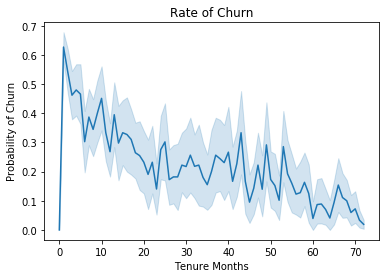

In [26]:
sns.lineplot(x='tenure', y='churn', data=train_df)
plt.ylabel('Probability of Churn')
plt.xlabel('Tenure Months')
plt.title("Rate of Churn")

2. Are there features that indicate a higher propensity to churn? like type of internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?

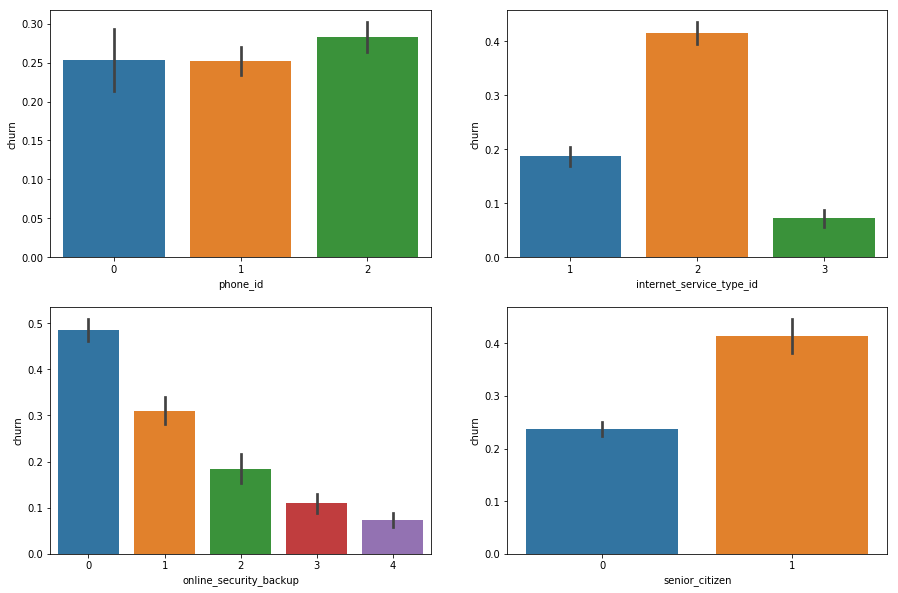

In [27]:
fig, ax = plt.subplots(2,2,figsize=(15,10))

sns.barplot(x='phone_id', y='churn', data=train_df,ax=ax[0,0])
sns.barplot(x='internet_service_type_id', y='churn', data=train_df,ax=ax[0,1])
sns.barplot(x='online_security_backup', y='churn', data=train_df,ax=ax[1,0])
sns.barplot(x='senior_citizen', y='churn', data=train_df,ax=ax[1,1])

3. Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?

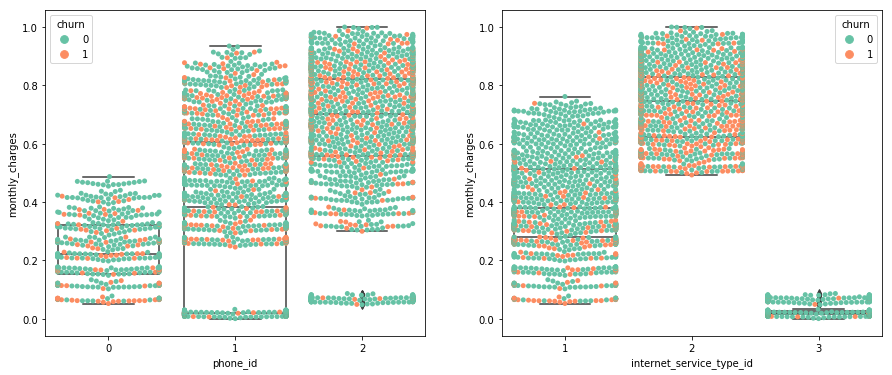

In [28]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

sns.boxplot(x="phone_id", y="monthly_charges", data=train_df, ax=ax[0],
           showcaps=True,boxprops={'facecolor':'None'}, showfliers=True,whiskerprops={'linewidth':0})
sns.swarmplot(x="phone_id", y="monthly_charges", data=train_df, ax=ax[0], hue="churn", palette="Set2")

sns.boxplot(x="internet_service_type_id", y="monthly_charges", data=train_df, ax=ax[1],
           showcaps=True,boxprops={'facecolor':'None'}, showfliers=True,whiskerprops={'linewidth':0})
sns.swarmplot(x="internet_service_type_id", y="monthly_charges", data=train_df, ax=ax[1], hue="churn", palette="Set2") 

4. If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

In [43]:
train_df['less_than_one'] = train_df['tenure_year'] <= 1
train_df['more_than_one'] = train_df['tenure_year'] > 1

test_df['less_than_one'] = test_df['tenure_year'] <= 1
test_df['more_than_one'] = test_df['tenure_year'] > 1

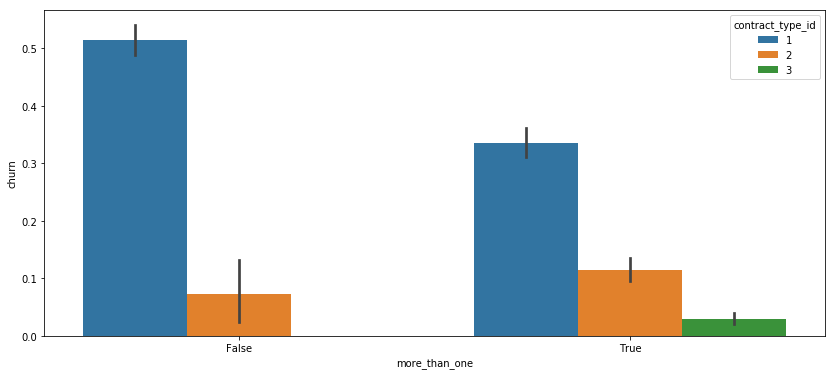

In [58]:
plt.figure(figsize=(14,6))
sns.barplot(x='more_than_one', y='churn', hue='contract_type_id', data=train_df)

**Hypothesis:*** Testing to see the difference between entry year customers and post 12 month customer as it relates to churn.

    A large t-score with customers more than 1 year tells us that the groups are different
    A small t-score with customers less than 1 year establishment tells us that the groups are similar

In [30]:
sp.stats.ttest_ind(train_df[train_df.tenure_year <= 1].monthly_charges.dropna(), train_df.churn)

Ttest_indResult(statistic=9.830566343480967, pvalue=1.1988936511239781e-22)

In [31]:
sp.stats.ttest_ind(train_df[train_df.tenure_year > 1].monthly_charges.dropna(), train_df.churn)

Ttest_indResult(statistic=27.56732365207348, pvalue=3.546705496180873e-160)

5. Controlling for services (phone_id, internet_service_type_id, online_security_backup, device_protection, tech_support, and contract_type_id), is the mean monthly_charges of those who have churned significantly different from that of those who have not churned? (Use a t-test to answer this.)

Does the phone_id have an effect on churn?

In [32]:
sp.stats.ttest_ind(train_df.phone_id, train_df.churn)

Ttest_indResult(statistic=96.62523722458897, pvalue=0.0)

Does the internet_service_type_id have an effect on churn?

In [33]:
sp.stats.ttest_ind(train_df.internet_service_type_id, train_df.churn)

Ttest_indResult(statistic=132.78427973501704, pvalue=0.0)

Does the online_security_backup have an effect on churn?

In [34]:
sp.stats.ttest_ind(train_df.online_security_backup, train_df.churn)

Ttest_indResult(statistic=66.03078247291516, pvalue=0.0)

Does the contract_type_id have an effect on churn?

In [35]:
sp.stats.ttest_ind(train_df.contract_type_id, train_df.churn)

Ttest_indResult(statistic=106.0519180040615, pvalue=0.0)

6. How much of ```monthly_charges``` can be explained by ```internet_service_type```? (hint: correlation test). State your hypotheses and your conclusion clearly.

In [36]:
np.corrcoef(train_df.monthly_charges, train_df.internet_service_type_id)[0, 1]

-0.32367274140588126

7. How much of ```monthly_charges``` can be explained by ```internet_service_type``` + phone service type (0, 1, or multiple lines). State your hypotheses and your conclusion clearly.

**Null Hypotheses:** Monthly charges can not be explained with the features internet service type and phone service type

Draw a nested barplot to show churn for internet_service_type_id and phone_id

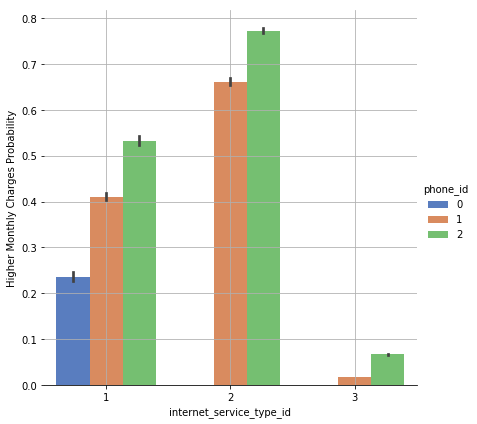

In [37]:
g = sns.catplot(x="internet_service_type_id", y="monthly_charges", hue="phone_id", data=train_df,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Higher Monthly Charges Probability")
plt.grid(b = True , which = "major")

**Conlusion:** The graph above shows the probability of higher monthly charges in each case of internet service type (No Internet, DSL, Fiber) and number of phone lines (0, 1, 1+)

8. Create visualizations exploring the interactions of variables (independent with independent and independent with dependent). The goal is to identify features that are related to churn, identify any data integrity issues, understand 'how the data works'. For example, we may find that all who have online services also have device protection. In that case, we don't need both of those. (The visualizations done in your analysis for questions 1-5 count towards the requirements below)

    - Each independent variable (except for customer_id) should be visualized in at least two plots, and at least 1 of those compares the independent variable with the dependent variable.

    - For each plot where x and y are independent variables, add a third dimension (where possible), of churn represented by color.

    - Use subplots when plotting the same type of chart but with different variables.

    - Adjust the axes as necessary to extract information from the visualizations (adjusting the x & y limits, setting the scale where needed, etc.)

    - Add annotations to at least 5 plots with a key takeaway from that plot.

    - Use plots from matplotlib, pandas and seaborn.

    - Use each of the following:

        - sns.heatmap
        - pd.crosstab (along with sns.heatmap)
        - pd.scatter_matrix
        - sns.barplot
        - sns.swarmplot
        - sns.pairplot
        - sns.jointplot
        - sns.relplot or plt.scatter
        - sns.distplot or plt.hist
        - sns.boxplot
        - plt.plot

    - Use at least one more type of plot that is not included in the list above.

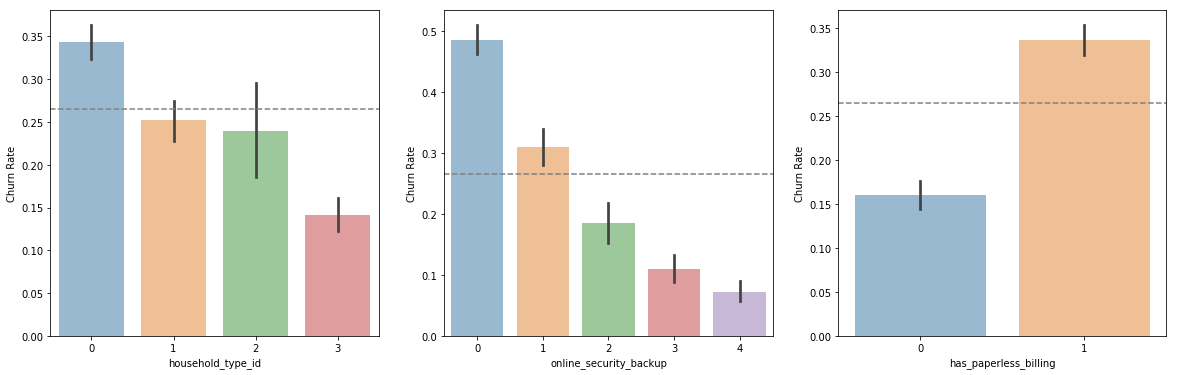

In [38]:
features = ['household_type_id', 'online_security_backup', 'has_paperless_billing']

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6))

churn_rate = train_df.churn.mean()

for i, feature in enumerate(features):
    sns.barplot(feature, 'churn', data=train_df, ax=ax[i], alpha=.5)
    ax[i].set_ylabel('Churn Rate')
    ax[i].axhline(churn_rate, ls='--', color='grey')

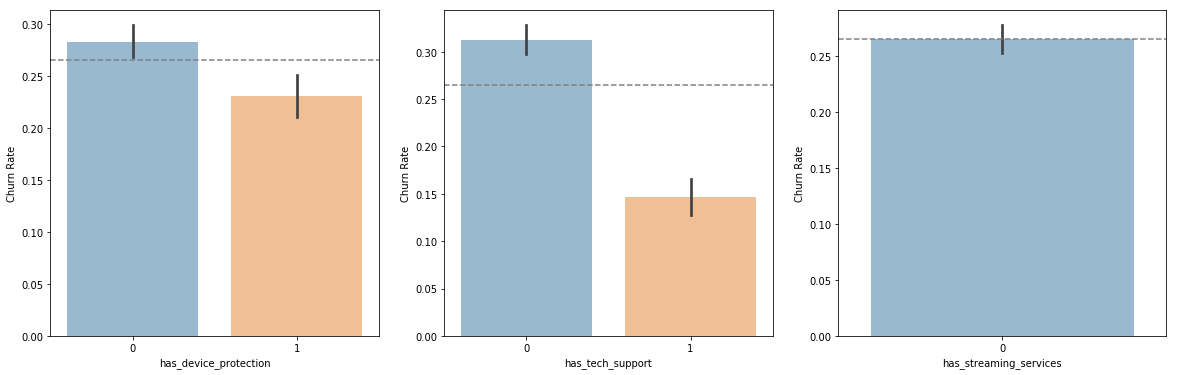

In [39]:
features = ['has_device_protection', 'has_tech_support', 'has_streaming_services']

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6))

churn_rate = train_df.churn.mean()

for i, feature in enumerate(features):
    sns.barplot(feature, 'churn', data=train_df, ax=ax[i], alpha=.5)
    ax[i].set_ylabel('Churn Rate')
    ax[i].axhline(churn_rate, ls='--', color='grey')

In [ ]:
plt.figure(figsize=(16,15))

sns.heatmap(train_df.corr(), annot=True, cmap="YlGnBu")

In [ ]:
sns.pairplot(train_df)

9. What can you say about each variable's relationship to churn, based on your initial exploration? If there appears to be some sort of interaction or correlation, assume there is no causal relationship and brainstorm (and document) ideas on reasons there could be correlation.

**Realtionship to churn**
1. 7 out of 25 customers with a multiple line phone plan churn
2. 2 out of 5 customers with the fiber optic internet option churn
3. 12 out of 25 customer without online securty or online backup churn
4. 2 out of 5 senior citizens churn
5. 17 out of 50 single member households churn
6. 17 out of 50 customers with paperless billing churn
7. 8 out of 25 customers that do not have device protection churn
8. 1 out of 3 customers without a technical support option churn
9. 1 out of 4 customers with a streaming service churn

10. Summarize your conclusions, provide clear answers to the specific questions, and summarize any takeaways/action plan from the work above.

## Modeling

1. Feature Selection: Are there any variables that seem to provide limited to no additional information? If so, remove them.

2. Train (fit, transform, evaluate) multiple different models, varying the model type and your meta-parameters.

In [61]:
train_df.columns

Index(['gender', 'senior_citizen', 'tenure', 'internet_service_type_id',
       'contract_type_id', 'payment_type_id', 'monthly_charges',
       'total_charges', 'churn', 'tenure_year', 'phone_id',
       'household_type_id', 'online_security_backup', 'has_paperless_billing',
       'has_device_protection', 'has_tech_support', 'has_streaming_services',
       'less_than_one', 'more_than_one'],
      dtype='object')

### Logistic Regression Model

In [83]:
logit = LogisticRegression(dual=True, random_state=123, fit_intercept=True)

In [84]:
logit.fit(train_df[['more_than_one', 'tenure', 'internet_service_type_id', 
                    'monthly_charges', 'phone_id', 'online_security_backup', 
                    'household_type_id', 'less_than_one']], train_df.churn)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=123, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [85]:
logit.predict(train_df[['more_than_one', 'tenure', 'internet_service_type_id', 
                    'monthly_charges', 'phone_id', 'online_security_backup', 
                    'household_type_id', 'less_than_one']])

array([0, 0, 0, ..., 0, 0, 1])

In [86]:
train_df['prediction'] = logit.predict(train_df[['more_than_one', 'tenure', 'internet_service_type_id', 
                    'monthly_charges', 'phone_id', 'online_security_backup', 
                    'household_type_id', 'less_than_one']])

In [87]:
(train_df.churn == train_df.prediction).sum() / train_df.shape[0]

0.7803245436105477

In [88]:
confusion_matrix(train_df.churn, train_df.prediction)

array([[3102,  520],
       [ 563,  745]])

In [89]:
cm = pd.DataFrame(confusion_matrix(train_df.churn, train_df.prediction),
             columns=['Pred -', 'Pred +'], index=['Actual -', 'Actual +'])

cm

,Pred -,Pred +
Actual -,3102,520
Actual +,563,745


In [90]:
print(classification_report(train_df.churn, train_df.prediction))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      3622
           1       0.59      0.57      0.58      1308

   micro avg       0.78      0.78      0.78      4930
   macro avg       0.72      0.71      0.72      4930
weighted avg       0.78      0.78      0.78      4930



In [91]:
train_df.churn.value_counts()

0    3622
1    1308
Name: churn, dtype: int64

In [92]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(train_df[['more_than_one', 'tenure', 'internet_service_type_id', 
                    'monthly_charges', 'phone_id', 'online_security_backup', 
                    'household_type_id', 'less_than_one']], train_df.churn)))

Accuracy of Logistic Regression classifier on training set: 0.78


### Random Forest Model

In [95]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=5, 
                            random_state=123)

In [96]:
rf.fit(train_df.drop(columns=['gender','churn','prediction','tenure']), train_df.churn)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [97]:
important_features = pd.Series(data=rf.feature_importances_,index=train_df.drop(columns=['gender', 'churn','prediction','tenure']).columns)
important_features.sort_values(ascending=False,inplace=True)
important_features

contract_type_id            0.224473
online_security_backup      0.172304
tenure_year                 0.159784
monthly_charges             0.100314
internet_service_type_id    0.079652
total_charges               0.064733
more_than_one               0.055305
payment_type_id             0.050817
less_than_one               0.048263
has_tech_support            0.013085
has_paperless_billing       0.011444
phone_id                    0.007214
senior_citizen              0.006750
household_type_id           0.004391
has_device_protection       0.001471
has_streaming_services      0.000000
dtype: float64

In [98]:
y_pred = rf.predict(train_df.drop(columns=['gender','churn','prediction','tenure']))
y_pred_proba = rf.predict_proba(train_df.drop(columns=['gender','churn','prediction','tenure']))

In [99]:
y_pred_proba[0:10]

array([[0.9573605 , 0.0426395 ],
       [0.82590421, 0.17409579],
       [0.94317663, 0.05682337],
       [0.98553664, 0.01446336],
       [0.80564519, 0.19435481],
       [0.38077601, 0.61922399],
       [0.52369682, 0.47630318],
       [0.88829405, 0.11170595],
       [0.8665922 , 0.1334078 ],
       [0.77211256, 0.22788744]])

In [100]:
print(confusion_matrix(train_df.churn, y_pred))

[[3373  249]
 [ 714  594]]


In [101]:
print(classification_report(train_df.churn, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      3622
           1       0.70      0.45      0.55      1308

   micro avg       0.80      0.80      0.80      4930
   macro avg       0.76      0.69      0.71      4930
weighted avg       0.79      0.80      0.79      4930



In [102]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(train_df.drop(columns=['gender','churn','prediction','tenure']), train_df.churn)))

Accuracy of random forest classifier on training set: 0.80


3. Compare evaluation metrics across all the models, and select the best performing model.

4. Test the final model (transform, evaluate) on your out-of-sample data (the testing data set). Summarize the performance. Interpret your results.

In [94]:
print('Accuracy of Logistic Regression classifier on test set: {:.2f}'
     .format(logit.score(test_df[['more_than_one', 'tenure', 'internet_service_type_id', 
                    'monthly_charges', 'phone_id', 'online_security_backup', 
                    'household_type_id', 'less_than_one']], test_df.churn)))

Accuracy of Logistic Regression classifier on test set: 0.78
